<h1>User 235, 250, 252 of 24 lags, 24 pre-step with two feature on LSTM </h1>

<h2>0.Parameters</h2>

In [1]:
import sys ; sys.path.append('../../util') # add utility folder to a system path
from fresh_parameters import parameters

param = parameters(n_repeats=1, 
                   n_data_period = 1, # 0 means 52 wk, 1 means 3 months, 2 means 4 weeks 3 means 1 week and else is 3 days
                   n_lags=24, 
                   n_seq_steps=24, 
                   n_pre_steps=24, n_features=2, 
                   batch_size=168, forcast_batch_size=1,
                   test_size=24 * 7 * 2, 
                   n_epochs=50, 
                   n_neurons=200,
                   b_stateful = False,
                   b_shuffle = True,
                   ratio_rec_dropout = 0.0, # recurrent dropout ratio
                   ratio_input_dropout = 0.2 , # input dropout ratio
                   ratio_validation=0.2,input_folder = "../../input/electricity/",
                   input_file_01 = "elect_235w_id.csv", debug_folder = "../../debug/",
                   b_load_model = False,
                   model_folder = "model_loc/",
                   model_json = "e235_e250_e252_shuffle_True_test_12wk_model.json",
                   model_weight = "e235_e250_e252_shuffle_True_test_12wk_weight.h5" 
                   )

NEURONS = param.n_neurons

In [2]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

IPython.keyboard_manager.command_shortcuts.add_shortcut('alt-r',
  function (event) {
      IPython.notebook.kernel.restart();
      setTimeout(function(){ IPython.notebook.execute_all_cells(); }, 1000);
      return false;
});

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
from fresh_general_util import time_start, time_end, set_seed
start_time = time_start() ; set_seed()

<h2>1. Load an input data and preprocess it</h2>

In [4]:
input_file_01_path = param.input_folder + param.input_file_01
print("input_file_01_path: ",input_file_01_path)

input_file_01_path:  ../../input/electricity/elect_235w_id.csv


In [5]:
from fresh_input_preprocess import load_input_personid, get_sample_period, sample_dataset
def load_input_file(input_file_path, param):
    series_raw = load_input_personid(input_file_path)
    # aggregate electric spendings by hour
    series = series_raw.resample("H").mean() ; #print(series.head())
    start_date, end_date = get_sample_period(param.n_data_period)
    series = sample_dataset(start_date, end_date, series, param.debug_folder, verbose=True)
    print(series.shape)
    return series

In [6]:
# For elect_235
series_01 = load_input_file(input_file_01_path, param)
# elect_250.csv
input_file_02_path = param.input_folder + "elect_250w_id.csv"
series_02 = load_input_file(input_file_02_path, param)
# elect_252.csv
input_file_03_path = param.input_folder + "elect_252w_id.csv"
series_03 = load_input_file(input_file_03_path, param)
import pandas as pd
series = pd.concat([series_01, series_02, series_03])

(2016, 2)
(2016, 2)
(2016, 2)


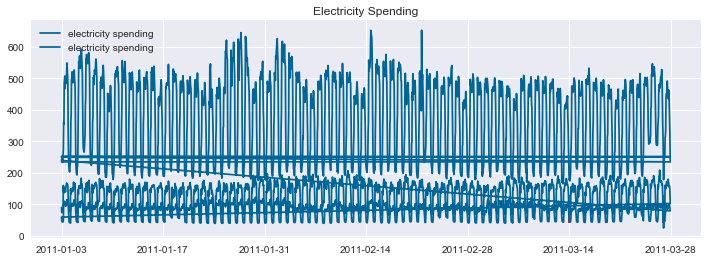

In [7]:
# Show the data set selected
from datetime import date
import matplotlib.pyplot as plt
import seaborn;seaborn.set()
plt.rcParams["figure.figsize"] = [12, 4]
plt.plot(series, label="electricity spending", color = '#006699')
plt.legend(loc='upper left')
plt.title("Electricity Spending")
plt.vlines(x=date(2011,3,14), ymin=40, ymax=130, color='r')
plt.vlines(x=date(2011,3,27), ymin=40, ymax=130, color='r')
plt.show()

<h2>2. Prepare Data using scale abd spliting into train and test</h2>

In [8]:
from numpy import concatenate
import numpy as np
from pandas import concat

from sklearn.preprocessing import MinMaxScaler

In [9]:
import math

In [10]:
from fresh_input_preprocess import prepare_data3, split_X_Y_2, series_to_supervised
# make a train and test data set scaled
scaler, train_scale, val_scale, test_scale = prepare_data3(series, param,verbose=False)

In [11]:
# Split X and Y for Train, Val and Test
x_train_scale, y_train_scale, x_val_scale, y_val_scale, x_test_scale, y_test_scale = split_X_Y_2(train_scale, 
                                                                                                 val_scale, test_scale, 
                                                                                                 param, y_index=2, 
                                                                                                 verbose=False)

<h2>3. Make a model and Experiment</h2>

In [12]:
from fresh_model import display_loss_train, save_model, load_model
from fresh_prediction import fit_lstm2, make_forecasts, forecast_lstm, evaluate_mse, invert_scale, convert_prediction
from fresh_prediction import make_mul_index, predict, predict2
import numpy as np

Using TensorFlow backend.


In [13]:
def train_experiment(param, neurons, scaler, x_train_scale, y_train_scale, x_val_scale, y_val_scale,x_test_scale, 
               y_test_true, verbose=False):
    error_scores = list()
    best_predictions = list()
    best_error_score = 9999.0
    best_history_list = list()

    
    for r in range(param.n_repeats):
        model, train_history_list = fit_lstm2(x_train_scale, y_train_scale, x_val_scale, y_val_scale,neurons, 
                                             param, verbose=verbose)
        old_weights = model.get_weights()                 
        rmse, inv_y_predict, inv_y_true = predict2(old_weights,param, scaler, 
            x_test_scale, y_test_true, verbose=verbose )    
        
        error_scores.append(rmse)
        if best_error_score > rmse:
            best_error_score = rmse
            best_predictions = inv_y_predict
            best_history_list = train_history_list
            best_model = model
    
    #if(param.b_load_model == False):
    #    save_model(best_model, param)
                
    return error_scores, best_error_score, best_predictions, inv_y_true, best_history_list, best_model

In [14]:
import pandas as pd

results = pd.DataFrame()
best_error_score = 9999
best_predictions = list()
best_history_list = list()

for e in [NEURONS] :
    results[str(e)], error_score, predictions, y_test_true, train_history_list, best_model = train_experiment(param, 
                                                                                            e,
                                                                                            scaler,
                                                                                            x_train_scale, 
                                                                                            y_train_scale,
                                                                                            x_val_scale, 
                                                                                            y_val_scale, 
                                                                                            x_test_scale, 
                                                                                            y_test_scale,
                                                                                            verbose=False)
    if best_error_score > error_score:
        best_error_score = error_score
        best_predictions = predictions
        best_history_list = train_history_list
        
print(results.describe())

# of epochs:  0
# of epochs:  10
# of epochs:  20
# of epochs:  30
# of epochs:  40
type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (313, 24)
TEST RMSE: 36.842
             200
count   1.000000
mean   36.842186
std          NaN
min    36.842186
25%    36.842186
50%    36.842186
75%    36.842186
max    36.842186


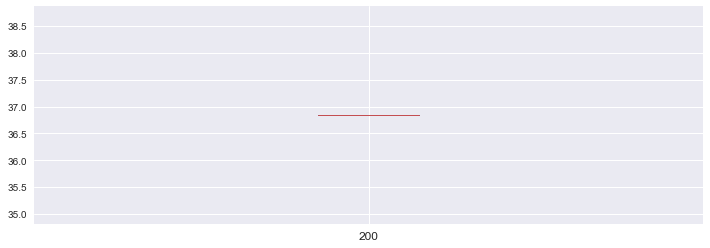

In [15]:
results.boxplot()
plt.show()

<h2>4. Evaluation</h2>

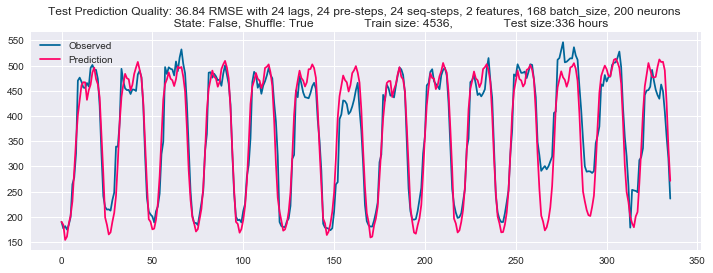

In [16]:
from fresh_prediction import display_obs_pred, evaluate, evaluate_with_model2
display_obs_pred("Test", best_error_score, param, 
                     y_test_true, best_predictions, x_train_scale,TEST_SIZE=param.test_size )    

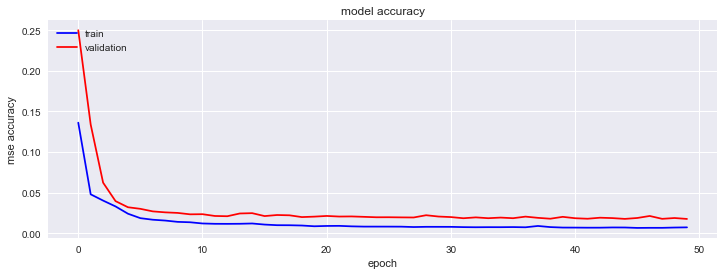

In [17]:
display_loss_train(best_history_list)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (4536, 24)
TEST RMSE: 29.818


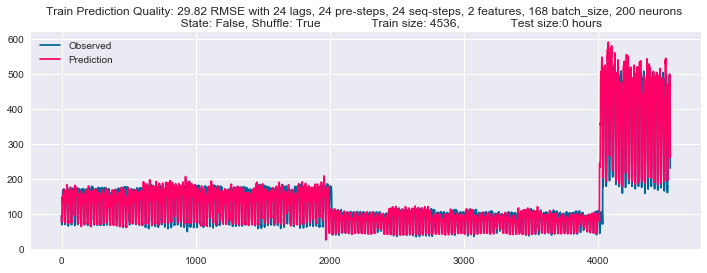

In [18]:
# Evaluate train data    
evaluate_with_model2("Train", best_model, param,scaler,
           x_train_scale, y_train_scale,verbose=False)    
 

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (1008, 24)
TEST RMSE: 44.175


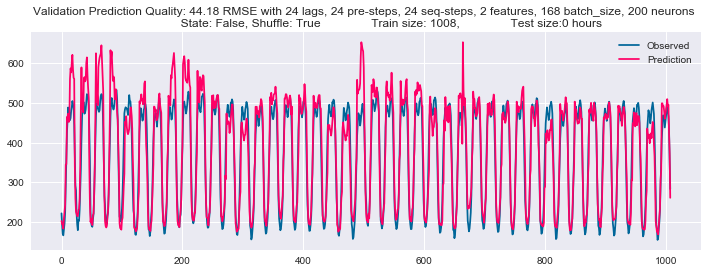

In [19]:
# Evaluate train data    
evaluate_with_model2("Validation", best_model,param,scaler,
           x_val_scale, y_val_scale, verbose=False)   

In [20]:
if(param.b_load_model == False):
    save_model(best_model, param)

Saved model to disk


In [ ]:
import sys
def inference(param, neurons, scaler, x_train_scale, y_train_scale, x_val_scale, y_val_scale,x_test_scale, 
               y_test_true, verbose=False):
    
    if param.b_load_model == False:
        print("A status of b_load_model is False")
        sys.exit()

    best_model = load_model(param)
    weights = best_model.get_weights() 
    best_error_score, best_predictions, y_true = predict2(weights,param, scaler, 
            x_test_scale, y_test_true, verbose=verbose )    
                
    return best_error_score, best_predictions, y_true, best_model


type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (4536, 24)
TEST RMSE: 29.818


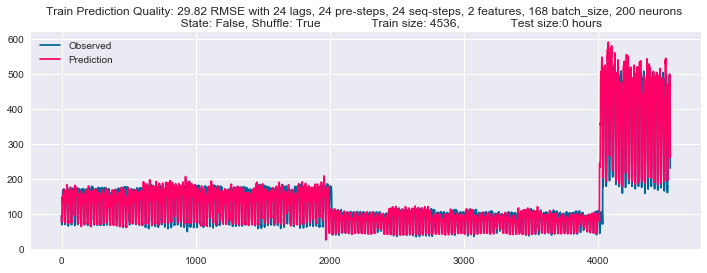

In [22]:
from fresh_model import display_loss_train, save_model, load_model
saved_model = load_model(param)
#saved_weights = best_model.get_weights() 
# Evaluate train data    



type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (313, 24)
TEST RMSE: 36.842


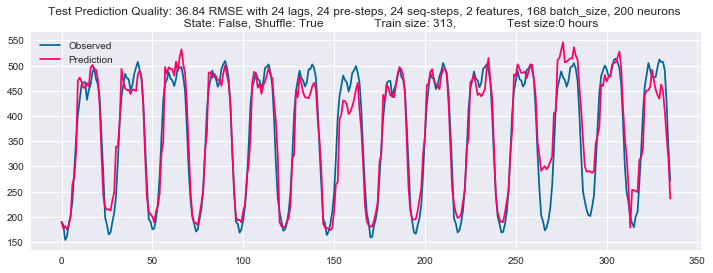

In [23]:
evaluate_with_model2("Test", saved_model, param,scaler,
           x_test_scale, y_test_scale,verbose=False)

In [45]:
param = parameters(n_repeats=1, 
                   n_data_period = 1, # 0 means 52 wk, 1 means 3 months, 2 means 4 weeks 3 means 1 week and else is 3 days
                   n_lags=24, 
                   n_seq_steps=24, 
                   n_pre_steps=24, n_features=2, 
                   batch_size=168, forcast_batch_size=1,
                   test_size=24 * 7 * 2, 
                   n_epochs=50, 
                   n_neurons=200,
                   b_stateful = False,
                   b_shuffle = True,
                   ratio_rec_dropout = 0.0, # recurrent dropout ratio
                   ratio_input_dropout = 0.2 , # input dropout ratio
                   ratio_validation=0.2,input_folder = "../../input/electricity/",
                   input_file_01 = "elect_252w_id.csv", debug_folder = "../../debug/",
                   b_load_model = True,
                   model_folder = "model_loc/",
                   model_json = "e235_e250_e252_shuffle_True_test_12wk_model.json",
                   model_weight = "e235_e250_e252_shuffle_True_test_12wk_weight.h5" 
                   )

NEURONS = param.n_neurons

In [46]:
input_file_01_path = param.input_folder + param.input_file_01
print("input_file_01_path: ",input_file_01_path)

input_file_01_path:  ../../input/electricity/elect_252w_id.csv


In [47]:
#from fresh_input_preprocess import load_input, get_sample_period, sample_dataset
from fresh_input_preprocess import get_sample_period, sample_dataset, load_input_personid
series_raw = load_input_personid(input_file_01_path)
# aggregate electric spendings by hour
series = series_raw.resample("H").mean() ; #print(series.head())
start_date, end_date = get_sample_period(param.n_data_period)
series = sample_dataset(start_date, end_date, series, param.debug_folder, verbose=True)
print(series.head(5))

                       elect_sp  person_id
date                                      
2011-01-03 00:00:00  239.522995      252.0
2011-01-03 01:00:00  242.930161      252.0
2011-01-03 02:00:00  246.337311      252.0
2011-01-03 03:00:00  235.255539      252.0
2011-01-03 04:00:00  233.130325      252.0


In [48]:
from fresh_input_preprocess import prepare_data3, split_X_Y_2, series_to_supervised
# make a train and test data set scaled
scaler, train_scale, val_scale, test_scale = prepare_data3(series, param,verbose=False)

In [49]:
# Split X and Y for Train, Val and Test
x_train_scale, y_train_scale, x_val_scale, y_val_scale, x_test_scale, y_test_scale = split_X_Y_2(train_scale, 
                                                                                                 val_scale, test_scale, 
                                                                                                 param, y_index=2, 
                                                                                                 verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (313, 24)
TEST RMSE: 88.240


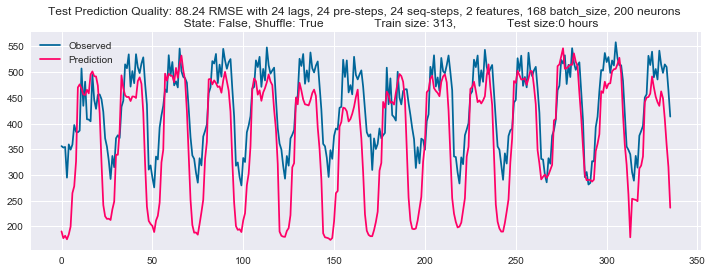

In [29]:
evaluate_with_model2("Test", saved_model, param,scaler,x_test_scale, y_test_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (313, 24)
TEST RMSE: 88.240


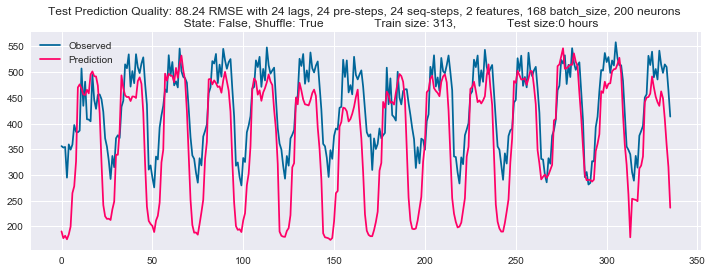

In [50]:
evaluate_with_model2("Test", best_model, param,scaler,x_test_scale, y_test_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (168, 24)
TEST RMSE: 95.959


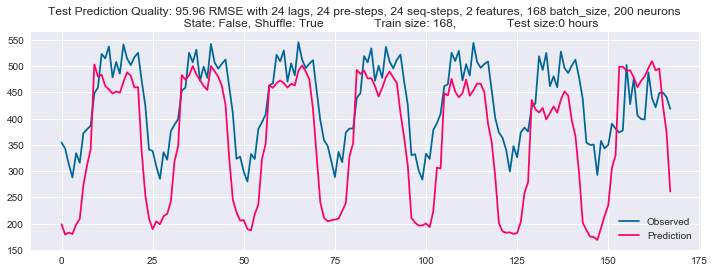

In [30]:
evaluate_with_model2("Test", saved_model, param,scaler,x_val_scale, y_val_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (168, 24)
TEST RMSE: 95.959


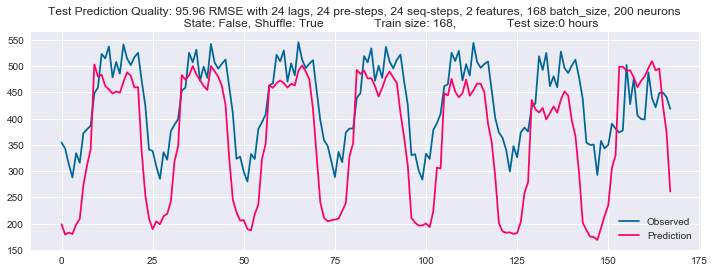

In [51]:
evaluate_with_model2("Test", best_model, param,scaler,x_val_scale, y_val_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (1344, 24)
TEST RMSE: 91.322


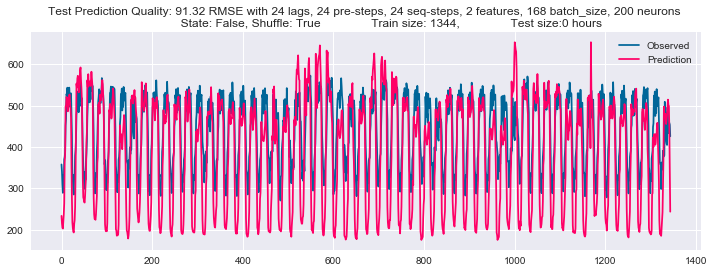

In [31]:
evaluate_with_model2("Test", saved_model, param,scaler,x_train_scale, y_train_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (1344, 24)
TEST RMSE: 91.322


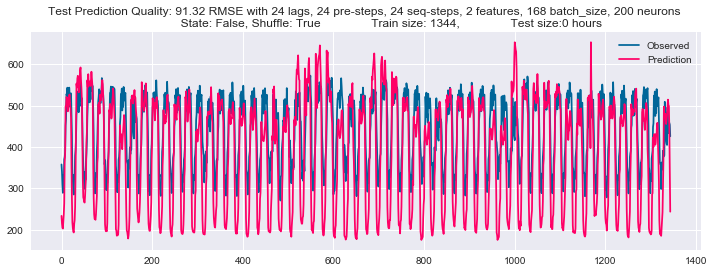

In [53]:
evaluate_with_model2("Test", best_model, param,scaler,x_train_scale, y_train_scale,verbose=False)

In [32]:
param = parameters(n_repeats=1, 
                   n_data_period = 1, # 0 means 52 wk, 1 means 3 months, 2 means 4 weeks 3 means 1 week and else is 3 days
                   n_lags=24, 
                   n_seq_steps=24, 
                   n_pre_steps=24, n_features=2, 
                   batch_size=168, forcast_batch_size=1,
                   test_size=24 * 7 * 2, 
                   n_epochs=50, 
                   n_neurons=200,
                   b_stateful = False,
                   b_shuffle = True,
                   ratio_rec_dropout = 0.0, # recurrent dropout ratio
                   ratio_input_dropout = 0.2 , # input dropout ratio
                   ratio_validation=0.2,input_folder = "../../input/electricity/",
                   input_file_01 = "elect_250w_id.csv", debug_folder = "../../debug/",
                   b_load_model = True,
                   model_folder = "model_loc/",
                   model_json = "e235_e250_e252_shuffle_True_test_12wk_model.json",
                   model_weight = "e235_e250_e252_shuffle_True_test_12wk_weight.h5" 
                   )

NEURONS = param.n_neurons

In [33]:
input_file_01_path = param.input_folder + param.input_file_01
print("input_file_01_path: ",input_file_01_path)
#from fresh_input_preprocess import load_input, get_sample_period, sample_dataset
from fresh_input_preprocess import get_sample_period, sample_dataset, load_input_personid
series_raw = load_input_personid(input_file_01_path)
# aggregate electric spendings by hour
series = series_raw.resample("H").mean() ; #print(series.head())
start_date, end_date = get_sample_period(param.n_data_period)
series = sample_dataset(start_date, end_date, series, param.debug_folder, verbose=True)
print(series.head(5))
from fresh_input_preprocess import prepare_data3, split_X_Y_2, series_to_supervised
# make a train and test data set scaled
scaler, train_scale, val_scale, test_scale = prepare_data3(series, param,verbose=False)
# Split X and Y for Train, Val and Test
x_train_scale, y_train_scale, x_val_scale, y_val_scale, x_test_scale, y_test_scale = split_X_Y_2(train_scale, 
                                                                                                 val_scale, test_scale, 
                                                                                                 param, y_index=2, 
                                                                                                 verbose=False)

input_file_01_path:  ../../input/electricity/elect_250w_id.csv
                      elect_sp  person_id
date                                     
2011-01-03 00:00:00  59.635223      250.0
2011-01-03 01:00:00  46.932121      250.0
2011-01-03 02:00:00  44.794228      250.0
2011-01-03 03:00:00  44.524319      250.0
2011-01-03 04:00:00  44.526993      250.0


type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (313, 24)
TEST RMSE: 16.821


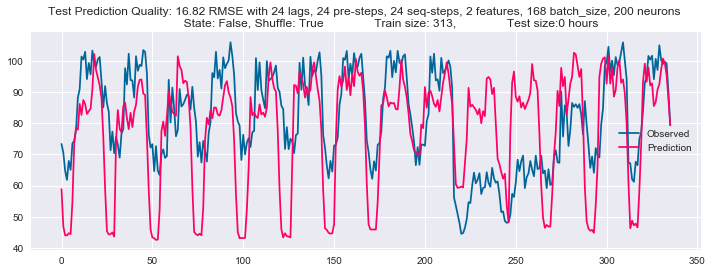

In [34]:
evaluate_with_model2("Test", saved_model, param,scaler,x_test_scale, y_test_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (168, 24)
TEST RMSE: 20.105


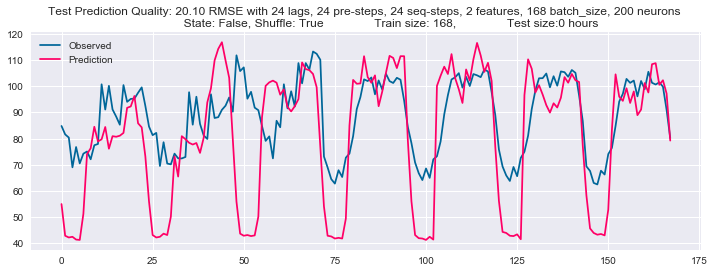

In [35]:
evaluate_with_model2("Test", saved_model, param,scaler,x_val_scale, y_val_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (1344, 24)
TEST RMSE: 17.274


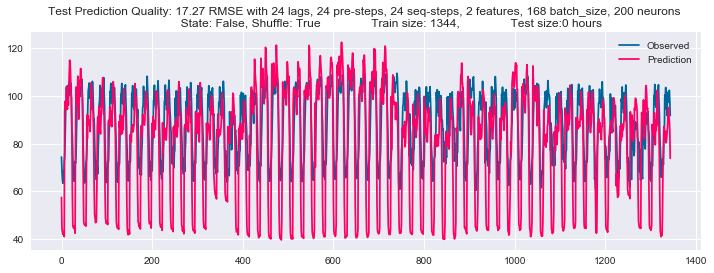

In [36]:
evaluate_with_model2("Test", saved_model, param,scaler,x_train_scale, y_train_scale,verbose=False)

In [37]:
param = parameters(n_repeats=1, 
                   n_data_period = 1, # 0 means 52 wk, 1 means 3 months, 2 means 4 weeks 3 means 1 week and else is 3 days
                   n_lags=24, 
                   n_seq_steps=24, 
                   n_pre_steps=24, n_features=2, 
                   batch_size=168, forcast_batch_size=1,
                   test_size=24 * 7 * 2, 
                   n_epochs=50, 
                   n_neurons=200,
                   b_stateful = False,
                   b_shuffle = True,
                   ratio_rec_dropout = 0.0, # recurrent dropout ratio
                   ratio_input_dropout = 0.2 , # input dropout ratio
                   ratio_validation=0.2,input_folder = "../../input/electricity/",
                   input_file_01 = "elect_235w_id.csv", debug_folder = "../../debug/",
                   b_load_model = True,
                   model_folder = "model_loc/",
                   model_json = "e235_e250_e252_shuffle_True_test_12wk_model.json",
                   model_weight = "e235_e250_e252_shuffle_True_test_12wk_weight.h5" 
                   )

NEURONS = param.n_neurons

In [38]:
input_file_01_path = param.input_folder + param.input_file_01
print("input_file_01_path: ",input_file_01_path)
#from fresh_input_preprocess import load_input, get_sample_period, sample_dataset
from fresh_input_preprocess import get_sample_period, sample_dataset, load_input_personid
series_raw = load_input_personid(input_file_01_path)
# aggregate electric spendings by hour
series = series_raw.resample("H").mean() ; #print(series.head())
start_date, end_date = get_sample_period(param.n_data_period)
series = sample_dataset(start_date, end_date, series, param.debug_folder, verbose=True)
print(series.head(5))
from fresh_input_preprocess import prepare_data3, split_X_Y_2, series_to_supervised
# make a train and test data set scaled
scaler, train_scale, val_scale, test_scale = prepare_data3(series, param,verbose=False)
# Split X and Y for Train, Val and Test
x_train_scale, y_train_scale, x_val_scale, y_val_scale, x_test_scale, y_test_scale = split_X_Y_2(train_scale, 
                                                                                                 val_scale, test_scale, 
                                                                                                 param, y_index=2, 
                                                                                                 verbose=False)

input_file_01_path:  ../../input/electricity/elect_235w_id.csv
                      elect_sp  person_id
date                                     
2011-01-03 00:00:00  90.023361      235.0
2011-01-03 01:00:00  74.240654      235.0
2011-01-03 02:00:00  77.165108      235.0
2011-01-03 03:00:00  76.775703      235.0
2011-01-03 04:00:00  74.437302      235.0


type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (313, 24)
TEST RMSE: 16.785


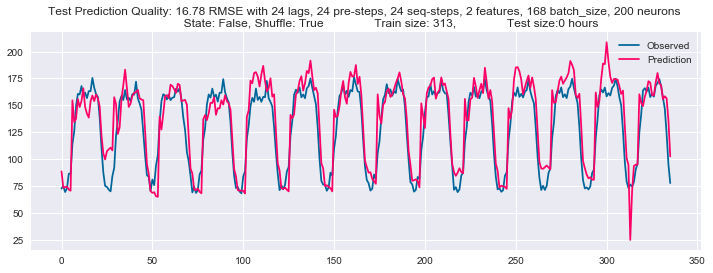

In [39]:
evaluate_with_model2("Test", saved_model, param,scaler,x_test_scale, y_test_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (168, 24)
TEST RMSE: 14.526


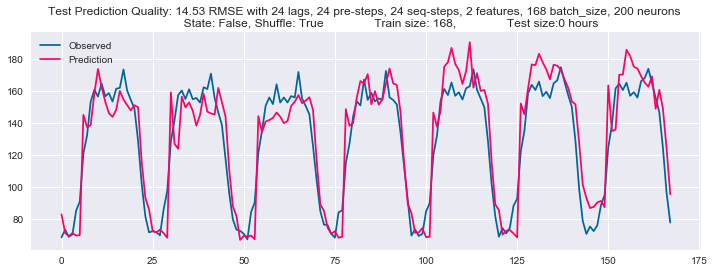

In [40]:
evaluate_with_model2("Test", saved_model, param,scaler,x_val_scale, y_val_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (1344, 24)
TEST RMSE: 16.476


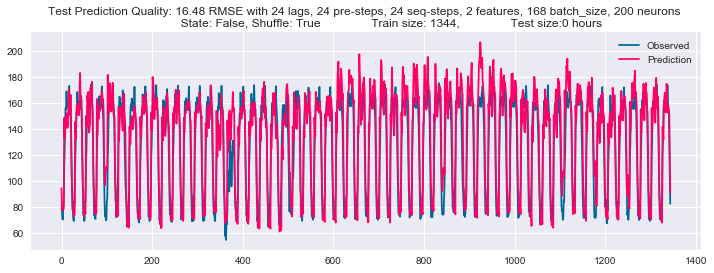

In [41]:
evaluate_with_model2("Test", saved_model, param,scaler,x_train_scale, y_train_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (313, 24)
TEST RMSE: 16.785


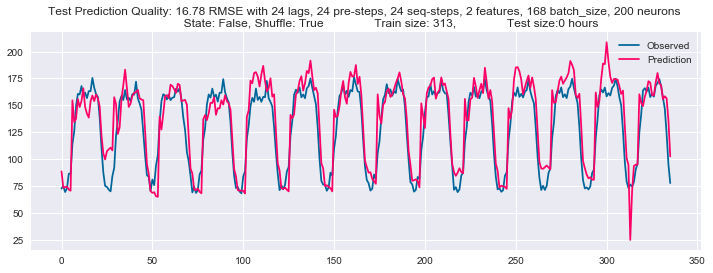

In [42]:
evaluate_with_model2("Test", best_model, param,scaler,x_test_scale, y_test_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (168, 24)
TEST RMSE: 14.526


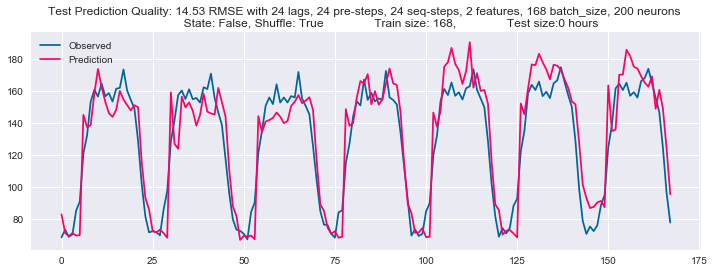

In [43]:
evaluate_with_model2("Test", best_model, param,scaler,x_val_scale, y_val_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (1344, 24)
TEST RMSE: 16.476


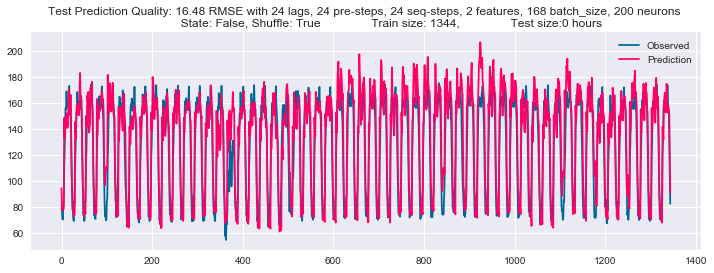

In [44]:
evaluate_with_model2("Test", best_model, param,scaler,x_train_scale, y_train_scale,verbose=False)

In [21]:
time_end(start_time)

start time:  1539089351.912979
end time:  1539090053.45758
Total exectution time (Min): 11.692410020033519


<h3>Reference:</h3><br>